In [15]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [16]:
### Pre-load all correlations datasets and one features example

CORRELATIONS_PATH = "data/correlations"
CORRELATIONS_DATASETS = ["train", "test", "test_comp_1", "test_comp_2", "test_comp_3"]
CORRELATIONS_CONFIGURATIONS = ["l20_o10_f1", "l15_o10_f1", "l10_o5_f1", "l10_o5_f0", "l5_o2.5_f1", "l5_o2.5_f0", "l2.5_o1.25_f1", "l2.5_o1.25_f0"]

EXTRACTED_PATH = "data/extracted/train"
EXAMPLE_EXTRACTED = "id00062_6O9RYsLu60k_00049"

def read_cors(path):
    cors = pd.read_csv(path, index_col="clip_name")
    print("The cor dataset was loaded successfully")
    return cors

def read_example(path)
    example = pd.read_csv(path)
    print("Example extracted features loaded successfully.")
    return example

The cor dataset was loaded successfully
Example extracted features loaded successfully.


In [ ]:
example_path = os.path.join(EXTRACTED_PATH, EXAMPLE_EXTRACTED)
example = read_example(example_path)

print(example.info())

In [ ]:
def preprocess_cors(df):
    DATAPOINTS_CNT = len(df)
    FEATURES_CNT = len(df.columns)
    CELLS_CNT = DATAPOINTS_CNT * FEATURES_CNT
    NAN_THRESHOLD_P = 0.01
    NAN_THRESHOLD_V = NAN_THRESHOLD_P * FEATURES_CNT

    # df.isnull() Return a bitmap for all cells (True/False)
    nan_total_ratio = df.isnull().sum().sum() / CELLS_CNT
    print(f"Ratio of NaN values in the dataset: {nan_total_ratio:.2%}")

    nan_row_ratio = df.isnull().any(axis=1).sum() / DATAPOINTS_CNT
    print(f"Ratio of datapoints which have NaN values in them: {nan_row_ratio:.2%}")

    nan_row_ratio = (df.isnull().sum(axis=1) > NAN_THRESHOLD_V).sum() / DATAPOINTS_CNT
    print(f"Ratio of datapoints which have more than {NAN_THRESHOLD_P:.2%} NaN values in them: {nan_row_ratio:.2%}, \
    [actual NaN features cnt thresh.: {NAN_THRESHOLD_V:.0f}]")

    nan_col_ratio = df.isnull().any().sum() / FEATURES_CNT
    print(f"Ratio of features which have NaN values in them: {nan_col_ratio:.2%}")

    # Remove rows with NaN values greater than the threshold
    df = df[df.isna().sum(axis=1) <= NAN_THRESHOLD_V]
    print(f"Datapoints left: {len(df)}, number of NaNs in the dataset: {df.isnull().sum().sum()}")

    # Replace NaNs in columns with their mean, ensuring that a column isn't completely NaN; if it is, put 0
    for col in df.columns:
        if df[col].isnull().sum() < len(df):  # Check if the column is not entirely NaN
            df[col].fillna(df[col].mean(), inplace=True)
        else:
            df[col].fillna(0, inplace=True)
    print("NaNs removed!")

    # Target value and additional information retrieval
    target = []
    for row in df.iterrows():
        clip_name = row[0]
        person_id = clip_name[2:7]
        video_id = clip_name[8:19]
        occurence_id = clip_name[20:25]
        clip_id = clip_name[27:32]
        target.append(person_id)

    df['target'] = target
    df['target'] = df['target'].astype('category') 

    # X - y split
    X = df.drop("target", axis=1) # clip-related feature
    y = df['target']              # target feature

    return X, y

In [28]:
# Standardize all data for the SVM

scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [29]:
def train_model(X_train: np.ndarray, X_test: np.ndarray, y_train: np.ndarray, y_test: np.ndarray):
    """
    Trains an SVM model using GridSearchCV and evaluates it on test data.

    Args:
        X_train (np.ndarray): Training features.
        X_test (np.ndarray): Testing features.
        y_train (np.ndarray): Training labels.
        y_test (np.ndarray): Testing labels.

    Returns:
        best_svm: The trained SVM model.
    """
    # Define the parameter grid for GridSearchCV
    param_grid = {
        'C': [0.01, 0.1, 1, 10, 100],
        'gamma': ['scale', 'auto', 0.01, 0.1, 1, 10],
        'kernel': ['rbf', 'poly', 'linear'],
    }


    # Configure GridSearchCV
    grid_search = GridSearchCV(
        SVC(decision_function_shape='ovo'),
        param_grid,
        cv=5,
        scoring='accuracy',
        n_jobs=-1,
    )

    # Fit GridSearchCV
    grid_search.fit(X_train, y_train)

    # Output the best parameters and best score
    print("\nGridSearchCV Results:")
    print(f"Best Parameters: {grid_search.best_params_}")
    print(f"Best Accuracy from GridSearch: {grid_search.best_score_:.4f}")

    # Retrieve the best estimator
    best_svm = grid_search.best_estimator_

    # Train the best SVM on the full training data
    best_svm.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = best_svm.predict(X_test)

    # Evaluate the model
    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    print(cm)

    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=[str(label) for label in np.unique(y_test)]))

    return best_svm

Train the full model on the regular data.

In [30]:
train_model(X_train, X_test, y_train, y_test)


GridSearchCV Results:
Best Parameters: {'C': 0.01, 'gamma': 'scale', 'kernel': 'linear'}
Best Accuracy from GridSearch: 0.8497

Confusion Matrix:
[[13  0  2  0  2]
 [ 0  8  0  0  1]
 [ 1  1 54  0  2]
 [ 0  0  2  8  4]
 [ 0  1  6  0 40]]

Classification Report:
              precision    recall  f1-score   support

       01003       0.93      0.76      0.84        17
       01005       0.80      0.89      0.84         9
       01006       0.84      0.93      0.89        58
       01007       1.00      0.57      0.73        14
       01010       0.82      0.85      0.83        47

    accuracy                           0.85       145
   macro avg       0.88      0.80      0.83       145
weighted avg       0.86      0.85      0.85       145



SVC(C=0.01, decision_function_shape='ovo', kernel='linear')

#### Simple visualization

/home/samarrik/miniconda3/envs/ms-env/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


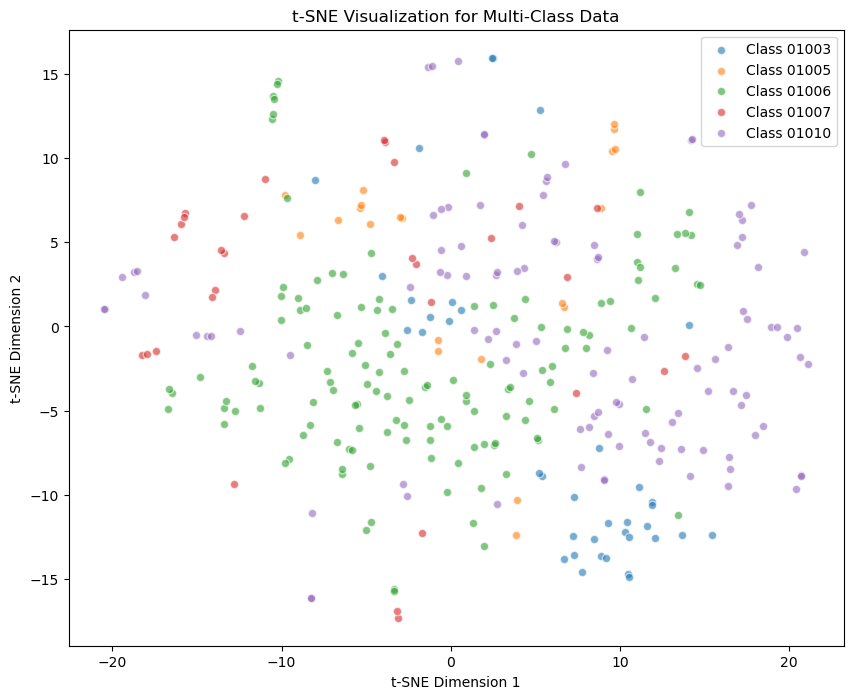

In [31]:
pca = PCA(n_components=60)  # Increased to 50 components
X_pca = pca.fit_transform(X_train)

# Apply t-SNE
tsne = TSNE(
    n_components=2,
    n_iter=3000,          # Increased iterations
    perplexity=40,        # Adjusted perplexity
    learning_rate=200,    # Adjusted learning rate
    random_state=42
)
X_tsne = tsne.fit_transform(X_pca)

# Plotting the t-SNE results for multi-class labels
plt.figure(figsize=(10, 8))

# Loop through unique classes in y_train
unique_classes = np.unique(y_train)
for class_label in unique_classes:
    # Filter data for the current class
    class_mask = (y_train == class_label)
    plt.scatter(
        X_tsne[class_mask, 0],
        X_tsne[class_mask, 1],
        label=f"Class {class_label}",
        alpha=0.6,
        edgecolors='w'
    )

plt.title('t-SNE Visualization for Multi-Class Data')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend()
plt.show()

In [ ]:
# Subset of features
# Clip length
# Influence of compression (resize)
# Split the dataset in 3 (combined/only_facial/only_body)